In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 97% 655M/675M [00:02<00:00, 258MB/s]
100% 675M/675M [00:03<00:00, 231MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cell-images-for-detecting-malaria.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
      weights='imagenet', #Taking the previous weights
      include_top = False, #Meaning we are not taking the dense layers ,meaning just taking the CNN part not the ANN part
      input_shape=(150,150,3) #This the input shape ,as our wish
)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
conv_base.trainable = False

In [10]:
import os
base_dir = "/content/cell_images/cell_images"
os.listdir(base_dir)

['Parasitized', 'Uninfected']

In [11]:
import tensorflow as tf
# Split data into training set and validation set
train_generator = tf.keras.preprocessing.image_dataset_from_directory (
    base_dir,
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=(150,150),
    batch_size=32
)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory (
    base_dir,
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=(150,150),
    batch_size=32
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [12]:
def process(image,label):
  image = tensorflow.cast(image/255. ,tensorflow.float32)
  return image,label

train_generator = train_generator.map(process)
validation_generator = validation_generator.map(process)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit( #For data augmentation use model.fit_generator rather than model.fit
                    train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
689/689 [==============================] - 71s 92ms/step - loss: 0.2387 - accuracy: 0.9059 - val_loss: 0.1697 - val_accuracy: 0.9370
Epoch 2/10
689/689 [==============================] - 62s 90ms/step - loss: 0.1799 - accuracy: 0.9307 - val_loss: 0.1556 - val_accuracy: 0.9390
Epoch 3/10
689/689 [==============================] - 62s 90ms/step - loss: 0.1536 - accuracy: 0.9436 - val_loss: 0.1707 - val_accuracy: 0.9350
Epoch 4/10
689/689 [==============================] - 62s 89ms/step - loss: 0.1406 - accuracy: 0.9481 - val_loss: 0.1521 - val_accuracy: 0.9398
Epoch 5/10
689/689 [==============================] - 63s 91ms/step - loss: 0.1326 - accuracy: 0.9510 - val_loss: 0.1473 - val_accuracy: 0.9434
Epoch 6/10
689/689 [==============================] - 62s 89ms/step - loss: 0.1239 - accuracy: 0.9541 - val_loss: 0.1798 - val_accuracy: 0.9343
Epoch 7/10
689/689 [==============================] - 62s 90ms/step - loss: 0.1187 - accuracy: 0.9570 - val_loss: 0.1428 - val_accuracy:

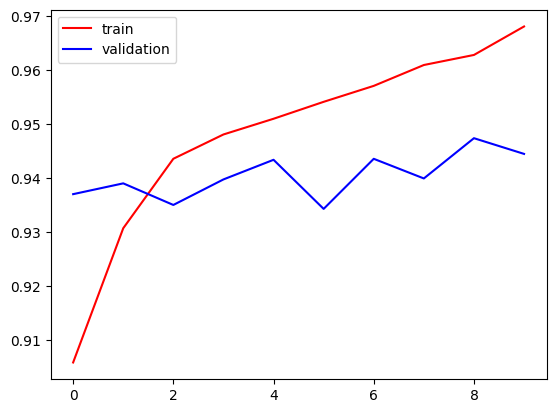

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

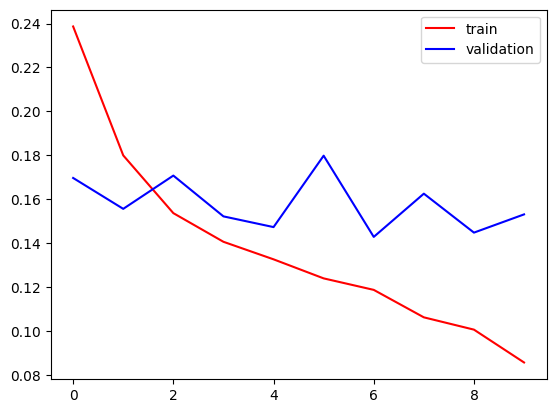

In [16]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [17]:
import cv2

In [18]:
test_img = cv2.imread('/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')

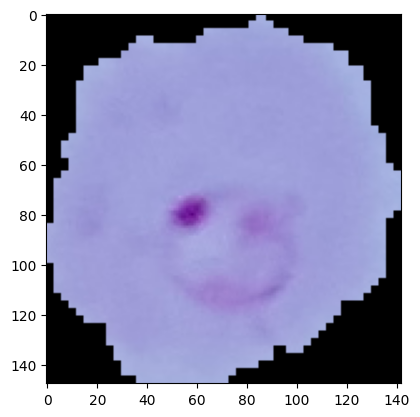

In [19]:
plt.imshow(test_img)

In [23]:
test_img = cv2.resize(test_img,(150,150))

In [24]:
test_input = test_img.reshape((1,150,150,3))

In [25]:
model.predict(test_input)

1/1 [==============================] - 1s 1s/step


array([[0.]], dtype=float32)

In [40]:
import numpy as np
a=np.argmax(model.predict(test_input), axis=1)
if(a==0):
    print("Uninfected")
else:
    print("Infected")

1/1 [==============================] - 0s 17ms/step
Uninfected


In [41]:
test_img = cv2.imread('/content/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png')

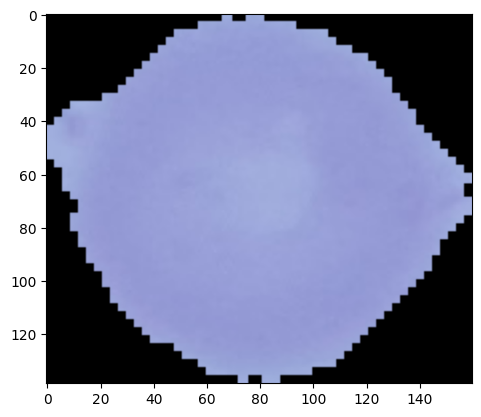

In [42]:
plt.imshow(test_img)

In [43]:
test_img = cv2.resize(test_img,(150,150))

In [44]:
test_input = test_img.reshape((1,150,150,3))

In [45]:
model.predict(test_input)

1/1 [==============================] - 0s 19ms/step


array([[1.]], dtype=float32)

In [46]:
import numpy as np
a=np.argmax(model.predict(test_input), axis=1)
if(a==0):
    print("Uninfected")
else:
    print("Infected")

1/1 [==============================] - 0s 18ms/step
Uninfected


In [47]:
# Save the model
model.save('malaria_detection_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')